# Sign Language Recognition using MediaPipe and LSTM

This notebook demonstrates the process of building a gesture recognition system using MediaPipe and a Long Short-Term Memory (LSTM) network. The system is designed to recognize a set of predefined gestures performed by a user.

**Workflow:**

1. **Data Acquisition:** We use MediaPipe's Holistic model to extract hand and pose landmarks from videos of different gestures.
2. **Data Preprocessing:** The extracted landmarks are preprocessed and organized into a format suitable for training the LSTM model.
3. **Model Training:** An LSTM network is trained on the preprocessed data to learn the patterns associated with each gesture.
4. **Model Evaluation:** The trained model is evaluated on a separate test set to assess its performance and identify potential areas for improvement.
5. **Model Testing:** The model is tested with a single video to showcase its gesture recognition capabilities.

**Libraries Used:**

* MediaPipe: For hand and pose estimation.
* OpenCV: For image and video processing.
* NumPy: For numerical computations.
* TensorFlow/Keras: For building and training the LSTM model.

**Objectives:**

* To build a sign language recognition system using MediaPipe and LSTM.
* To demonstrate the process of data acquisition, preprocessing, model training, and evaluation.

# Specifying Libraries and Functions

**IMPORTANT:**
Before running this notebook, please make sure to mount your Google Drive to access the necessary files. You can do this by clicking on the "Mount Drive" button in the file explorer on the left.

In [ ]:
!pip install "numpy==1.26.4" "mediapipe==0.10.21" "opencv-python==4.10.0.84" "joblib"

In [ ]:
# Install required libraries
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion from BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is no longer writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)   # Color conversion RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    # Draw right connections

def draw_styled_landmarks(image,results):

    # Draw pose connection
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw left hand connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw right hand connection
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, lh, rh])



/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Test if the frame is reachable
import os
print(os.path.exists("/content/drive/MyDrive/MSL_Project/frame-32.jpeg"), "/content/drive/MyDrive/MSL_Project/frame-32.jpeg")

True /content/drive/MyDrive/MSL_Project/frame-32.jpeg


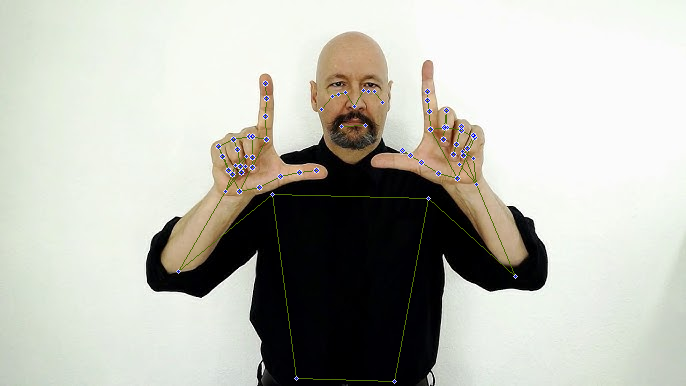

In [ ]:
def detect_hand_landmarks(image_path):
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Make detections
        image, results = mediapipe_detection(image, holistic)

        # Draw landmarks to the frame
        draw_styled_landmarks(image,results)

        # Convert the image back to BGR for OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Display the image with hand landmarks
        cv2_imshow(image)


# Testing mediapipe
# Path to your own image file
image_path = '/content/drive/MyDrive/MSL_Project/frame-32.jpeg'

# Call the function to detect hand landmarks
detect_hand_landmarks(image_path)


In [ ]:
# Specify the path you upload the videos in the Google Drive
video_directory = r'/content/drive/MyDrive/MSL_Project/videos'

# Get all file names in the directory
gestures_files = os.listdir(video_directory)

# Specify the gestures
gestures = np.array(gestures_files)
print(gestures)

['minum' 'berjalan' 'berlari' 'bola' 'dari' 'hi' 'jangan' 'mohon' 'pen'
 'teh tarik' 'tolong']


# Data Acquisition
In this part, it process a every gesture videos in the dataset folder to extract and save keypoint data for hand, body, and face landmarks using MediaPipe's Holistic model. For each gesture category, it iterates through associated video files, detects landmarks in up to 30 frames per video, and stores the extracted keypoints in .npy files.

In [ ]:
# Specify your path to store landmarks files
train_dataset_path = '/content/drive/MyDrive/MSL_Project/train_dataset'

In [ ]:
for ges in gestures:

    # Specify the video path
    data_path = os.path.join(video_directory, ges)
    data_video = os.listdir(data_path)

    for vid in data_video:

        if not os.path.exists(os.path.join(train_dataset_path)):
            os.makedirs(train_dataset_path)

        landmark_path = os.path.join(train_dataset_path, ges, 'landmarks' + vid)
        video_path = os.path.join(video_directory, ges, vid)
        print(video_path)


        # Locate the video dataset
        video = cv2.VideoCapture(video_path)

        count = 0
        frame_count = 0

        # Set mediapipe model
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            while True:
                ret, frame = video.read()

                if not ret or frame_count == 30:
                    # Break the loop if there are no more frames
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks to the frame
                draw_styled_landmarks(image,results)

                # Check if hands are present
                # This part ensures that only frames with detected hand landmarks are saved.
                if results.left_hand_landmarks or results.right_hand_landmarks:

                    # Create landmark files
                    if not os.path.exists(landmark_path):
                        os.makedirs(landmark_path)

                    # Extract keypoint
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(landmark_path, str(count + 1))
                    np.save(npy_path, keypoints)
                    print(f"Extract: {npy_path}")

                    frame_count += 1

                count += 1



Streaming output truncated to the last 5000 lines.
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/31
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/32
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/33
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/34
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/35
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/36
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/37
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/38
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksjangan_11_04_03.mp4/39
Extract: /content/drive/MyDrive/MSL_Project/train_dataset/jangan/landmarksja

# Data Preprocess and Label

This part processes  landmark files (.npy files) for different gestures stored in the directory. Each gesture is represented as a sequence of landmarks (e.g., coordinates of hands, face, and pose). The goal is to extract these sequences from stored files, organize them into a dataset (gestures_sequence), and pair them with corresponding numeric labels (labels). These labels are generated using a mapping from gesture names to integers (label_map).

### Expected Output
1. [Structure of gestures_sequence] A NumPy array with shape (N, F, L), where:
- N = number of gesture instances (e.g., number of processed videos or data samples).
- F = number of frames per gesture instance (variable depending on the video length).
- L = number of landmarks per frame (for this case 126 landmarks, which are total landmarks of hands, face and pose).

2. [Structure of labels] A NumPy array with shape (N,) containing numeric labels corresponding to the gestures.

In [ ]:
import shutil
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

source_folder = "/content/drive/MyDrive/MSL_Project/train_dataset"
destination_folder = "/content/temp_dataset"
num_threads = 16

def copy_file(src_path, dst_path):
    # Create the directory structure if it doesn't exist
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy2(src_path, dst_path)

def copy_directory_parallel(src, dst, workers=16):
    if os.path.exists(dst):
        print(f"Deleting existing {dst} to ensure clean copy...")
        shutil.rmtree(dst)

    print("Scanning files...")
    files_to_copy = []
    for root, dirs, files in os.walk(src):
        for file in files:
            source_file = os.path.join(root, file)
            relative_path = os.path.relpath(source_file, src)
            dest_file = os.path.join(dst, relative_path)
            files_to_copy.append((source_file, dest_file))

    print(f"Found {len(files_to_copy)} files. Starting parallel copy...")

    # Run the copy in parallel
    with ThreadPoolExecutor(max_workers=workers) as executor:
        list(tqdm(executor.map(lambda p: copy_file(*p), files_to_copy), total=len(files_to_copy)))

    print("Copy complete!")

copy_directory_parallel(source_folder, destination_folder, num_threads)

Scanning files...
Found 22217 files. Starting parallel copy...


  0%|          | 0/22217 [00:00<?, ?it/s]

Copy complete!


In [ ]:
train_dataset_path = '/content/temp_dataset'
save_path = '/content/drive/MyDrive/MSL_Project'

In [ ]:
label_map = {label: num for num, label in enumerate(gestures)}
len(label_map)

11

In [ ]:


gesture_sequence, labels = [], []

for gs in gestures:
    gesture = []

    for fname in os.listdir(os.path.join(train_dataset_path, gs)):
        path = os.path.join(train_dataset_path, gs, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    for no in gesture:
        load_path = os.path.join(train_dataset_path, gs, no)
        npy_files = sorted([f for f in os.listdir(load_path) if f.endswith('.npy')])
        npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        video = []
        for npy in npy_files:
            video.append(np.load(os.path.join(load_path, npy)))
            # print(os.path.join(load_path, npy))

        gesture_sequence.append(video)
        labels.append(label_map[gs])

    # Calculate the maximum sequence length for this gesture
    max_len = max(len(seq) for seq in gesture_sequence)

    # Pad shorter sequences with zeros to match the maximum length
    gesture_sequence = [
        seq + [[0] * seq[0].shape[0]] * (max_len - len(seq))  # Pad with zeros
        for seq in gesture_sequence
    ]

    print(np.array(gesture_sequence).shape, np.array(labels).shape)

X = np.array(gesture_sequence)
y = np.array(labels)

np.save(os.path.join(save_path, 'X_TRAIN_2.npy'), X)
np.save(os.path.join(save_path, 'y_TRAIN_2.npy'), y)

(27, 30, 258) (27,)
(54, 30, 258) (54,)
(80, 30, 258) (80,)
(107, 30, 258) (107,)
(134, 30, 258) (134,)
(532, 30, 258) (532,)
(636, 30, 258) (636,)
(693, 30, 258) (693,)
(720, 30, 258) (720,)
(747, 30, 258) (747,)
(803, 30, 258) (803,)


# Training Model

In [ ]:
# RUN FROM HERE TO TRAIN IF NO CHANGES TO DATA PREPROCESSING
save_path = '/content/drive/MyDrive/MSL_Project'
X = np.load(os.path.join(save_path, 'X_TRAIN_2.npy'))
y = np.load(os.path.join(save_path, 'y_TRAIN_2.npy'))

print(X.shape, y.shape)

(803, 30, 258) (803,)


In [ ]:
# Remove gloss "Hi"
target_class = "hi"

if target_class in gestures:
    remove_index = np.where(gestures == target_class)[0][0]
    mask = y != remove_index

    X_filtered = X[mask]
    y_filtered = y[mask]

    y_filtered_remapped = y_filtered.copy()
    y_filtered_remapped[y_filtered > remove_index] -= 1

    gestures_filtered = np.delete(gestures, remove_index)

    print(f"Original X shape: {X.shape}")
    print(f"Filtered X shape: {X_filtered.shape}")
    print(f"New class list: {gestures_filtered}")

    np.save(os.path.join(save_path, 'X_TRAIN_no_hi.npy'), X_filtered)
    np.save(os.path.join(save_path, 'y_TRAIN_no_hi.npy'), y_filtered_remapped)

    X = X_filtered
    y = y_filtered_remapped
    gestures = gestures_filtered

else:
    print(f"Class '{target_class}' not found in the gestures list.")

Original X shape: (803, 30, 258)
Filtered X shape: (405, 30, 258)
New class list: ['minum' 'berjalan' 'berlari' 'bola' 'dari' 'jangan' 'mohon' 'pen'
 'teh tarik' 'tolong']


CLASS NAME           | COUNT      | PERCENTAGE
--------------------------------------------------
minum                | 27         | 6.7%
berjalan             | 27         | 6.7%
berlari              | 26         | 6.4%
bola                 | 27         | 6.7%
dari                 | 27         | 6.7%
jangan               | 104        | 25.7%
mohon                | 57         | 14.1%
pen                  | 27         | 6.7%
teh tarik            | 27         | 6.7%
tolong               | 56         | 13.8%


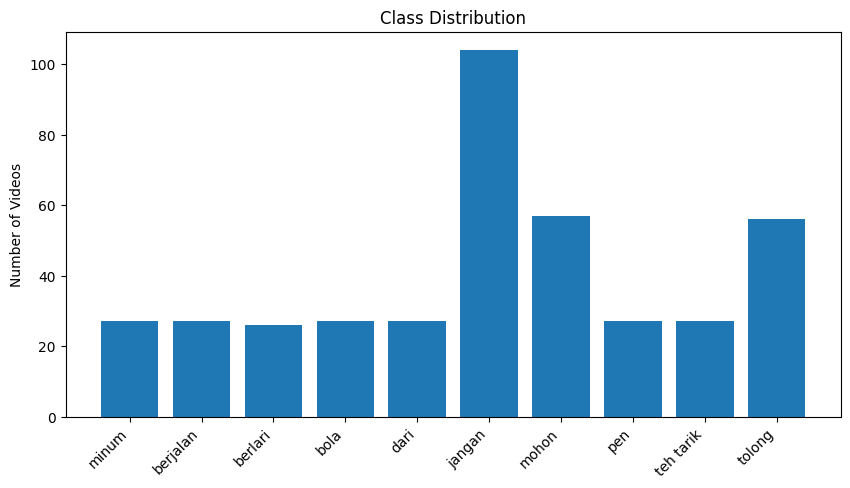

In [ ]:
# Count the occurrences of each class
unique, counts = np.unique(y, return_counts=True)

print(f"{'CLASS NAME':<20} | {'COUNT':<10} | {'PERCENTAGE'}")
print("-" * 50)

total_samples = len(y)
for class_index, count in zip(unique, counts):
    class_name = gestures[class_index]
    percentage = (count / total_samples) * 100
    print(f"{class_name:<20} | {count:<10} | {percentage:.1f}%")

plt.figure(figsize=(10, 5))
plt.bar([gestures[i] for i in unique], counts)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.ylabel('Number of Videos')
plt.show()

In [ ]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class Weights:", class_weights)

Class Weights: [1.5        1.5        1.55769231 1.5        1.5        0.38942308
 0.71052632 1.5        1.5        0.72321429]


In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler

# Split the dataset into training, validation, and testing set
# Ratio: 70:10:20
X_temp, X_test_raw, y_temp, y_test = train_test_split(X, to_categorical(y).astype(int), test_size=0.2, stratify=y, random_state=42)
# X_temp (80% of original) => Want 10% of original for val => 0.1/0.8=0.125
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

scaler = StandardScaler()

N, T, F = X_train_raw.shape
X_train_flat = X_train_raw.reshape(-1, F)
X_train_scaled = scaler.fit_transform(X_train_flat)
X_train = X_train_scaled.reshape(N, T, F)

N_val, T_val, F_val = X_val_raw.shape
X_val_flat = X_val_raw.reshape(-1, F_val)
X_val_scaled = scaler.transform(X_val_flat)
X_val = X_val_scaled.reshape(N_val, T_val, F_val)

N_test, T_test, F_test = X_test_raw.shape
X_test_flat = X_test_raw.reshape(-1, F_test)
X_test_scaled = scaler.transform(X_test_flat)
X_test = X_test_scaled.reshape(N_test, T_test, F_test)

print(f"Train Shape: {X_train.shape}")
print(f"Val Shape:   {X_val.shape}")
print(f"Test Shape:  {X_test.shape}")

print("Saving scaler to scaler.bin...")
joblib.dump(scaler, 'scaler.bin')
print("Scaler saved successfully!")

Train Shape: (283, 30, 258)
Val Shape:   (41, 30, 258)
Test Shape:  (81, 30, 258)
Saving scaler to scaler.bin...
Scaler saved successfully!


In [ ]:
# Convert data to PyTorch tensors and move to the GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train.argmax(axis=1), dtype=torch.long).to(device)  # Convert to class indices
y_val = torch.tensor(y_val.argmax(axis=1), dtype=torch.long).to(device)  # Convert to class indices
y_test = torch.tensor(y_test.argmax(axis=1), dtype=torch.long).to(device)  # Convert to class indices

In [ ]:
# Define your custom LSTM model and move to the GPU
# class CustomLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(CustomLSTM, self).__init__()
#         self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
#         self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 64)
#         self.fc2 = nn.Linear(64, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 32)
#         self.fc5 = nn.Linear(32, 32)
#         self.output_layer = nn.Linear(32, num_classes)

#     def forward(self, x):
#         x, _ = self.lstm1(x)
#         x, _ = self.lstm2(x)
#         x, _ = self.lstm3(x)
#         x = torch.relu(self.fc1(x[:, -1, :]))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         x = torch.relu(self.fc5(x))
#         x = self.output_layer(x)
#         return x

from torch.optim.lr_scheduler import ReduceLROnPlateau

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.output_layer = nn.Linear(64, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.output_layer(out)
        return out

input_size = 258
hidden_size = 64
num_classes = len(gestures)
model = CustomLSTM(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Weighted loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# STOP HERE IF NO TRAINING

In [ ]:
# Train the model on the GPU
num_epochs = 200
loss_history = []
val_loss_history = []
accuracy_history = []
val_accuracy_history = []

best_val_loss = float('inf')
best_model_filename = 'best_model.pth'
save_msg = ''

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad() # Reset gradients
    outputs = model(X_train) # Forward pass
    loss = criterion(outputs, y_train) # Compute loss
    loss.backward() # Backward pass
    optimizer.step() # Update weights

    train_preds = torch.argmax(outputs, dim=1)
    train_acc = (train_preds == y_train).float().mean().item()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val).float().mean().item()

    scheduler.step(val_loss)

    loss_history.append(loss.item())
    val_loss_history.append(val_loss.item())
    accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_filename)
        save_msg = f"--> Saved best model at Epoch {epoch+1} (Val Loss: {best_val_loss:.4f})"

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | '
              f'Loss: {loss.item():.4f} Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss.item():.4f} Val Acc: {val_acc:.4f} {save_msg}')
        save_msg = ''

# Save the trained model
print('Saving trained model...')
model_filename = 'trained_model.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")

# Evaluate the model
model.eval()
print('Loading best val loss model...')
model.load_state_dict(torch.load(best_model_filename, map_location=device))

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    accuracy = (test_outputs.argmax(dim=1) == y_test).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

Epoch [10/200] | Loss: 2.2409 Acc: 0.2756 | Val Loss: 2.2222 Val Acc: 0.3902 --> Saved best model at Epoch 10 (Val Loss: 2.2222)
Epoch [20/200] | Loss: 2.0691 Acc: 0.4912 | Val Loss: 2.0429 Val Acc: 0.5122 --> Saved best model at Epoch 20 (Val Loss: 2.0429)
Epoch [30/200] | Loss: 1.7367 Acc: 0.5618 | Val Loss: 1.6653 Val Acc: 0.5122 --> Saved best model at Epoch 30 (Val Loss: 1.6653)
Epoch [40/200] | Loss: 1.2613 Acc: 0.6643 | Val Loss: 1.1554 Val Acc: 0.6098 --> Saved best model at Epoch 40 (Val Loss: 1.1554)
Epoch [50/200] | Loss: 0.7869 Acc: 0.7915 | Val Loss: 0.7540 Val Acc: 0.7561 --> Saved best model at Epoch 50 (Val Loss: 0.7540)
Epoch [60/200] | Loss: 0.5044 Acc: 0.8481 | Val Loss: 0.6013 Val Acc: 0.8293 --> Saved best model at Epoch 60 (Val Loss: 0.6013)
Epoch [70/200] | Loss: 0.3434 Acc: 0.8869 | Val Loss: 0.5792 Val Acc: 0.8780 --> Saved best model at Epoch 68 (Val Loss: 0.5662)
Epoch [80/200] | Loss: 0.2653 Acc: 0.9505 | Val Loss: 0.5087 Val Acc: 0.9512 --> Saved best model

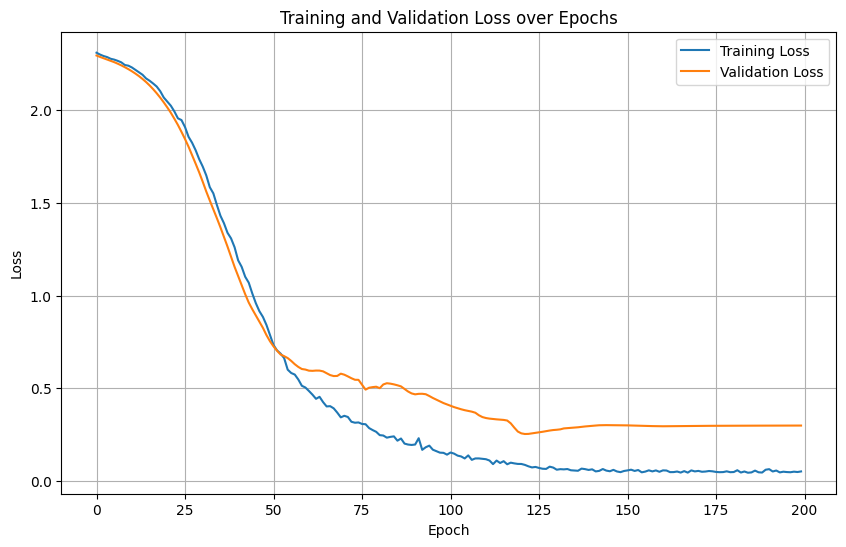

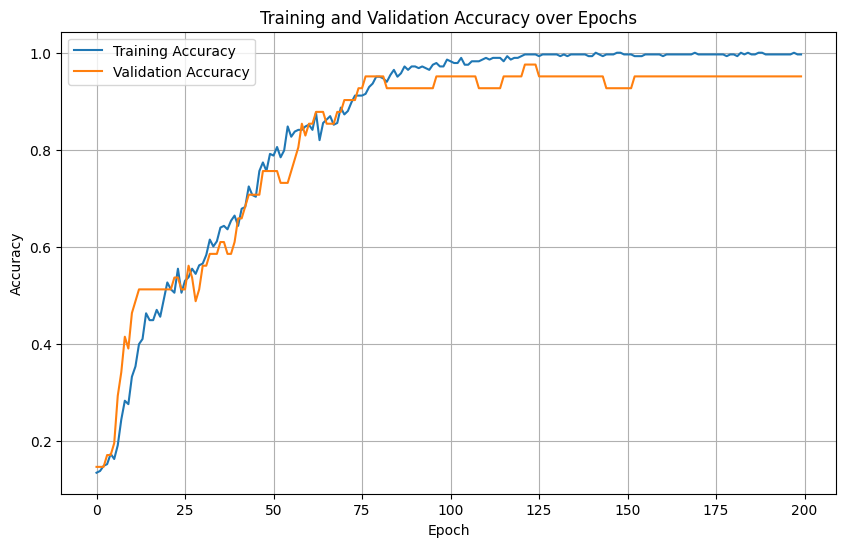

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

Evaluates the performance of the trained model. The goal is to assess how well the model generalizes to unseen data and identify potential areas for improvement.

**Evaluation Metrics:**

1. **Accuracy:** Measures the overall correctness of the model's predictions.
2. **Confusion Matrix:** Provides a detailed breakdown of the model's predictions, showing the number of true positives, true negatives, false positives, and false negatives for each gesture class.
3. **Classification Report:** Offers a comprehensive overview of the model's performance, including precision, recall, F1-score, and support for each gesture class.

**Visualization:**

* Confusion Matrix Heatmap: A visual representation of the confusion matrix using a heatmap, aiding in understanding the model's performance across different classes.
* Classification Report Heatmap: A heatmap visualizing the classification report, providing a quick overview of key metrics for each class.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

Loading final trained model...
Test Loss: 0.4802, Test Accuracy: 0.9012
Confusion Matrix:
[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  2  0  0  0]
 [ 0  0  0  1  4  0  0  0  0  1]
 [ 0  0  0  0  0 21  0  0  0  0]
 [ 0  0  0  1  0  0 11  0  0  0]
 [ 1  0  0  0  0  0  0  4  0  0]
 [ 0  1  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  1 10]]


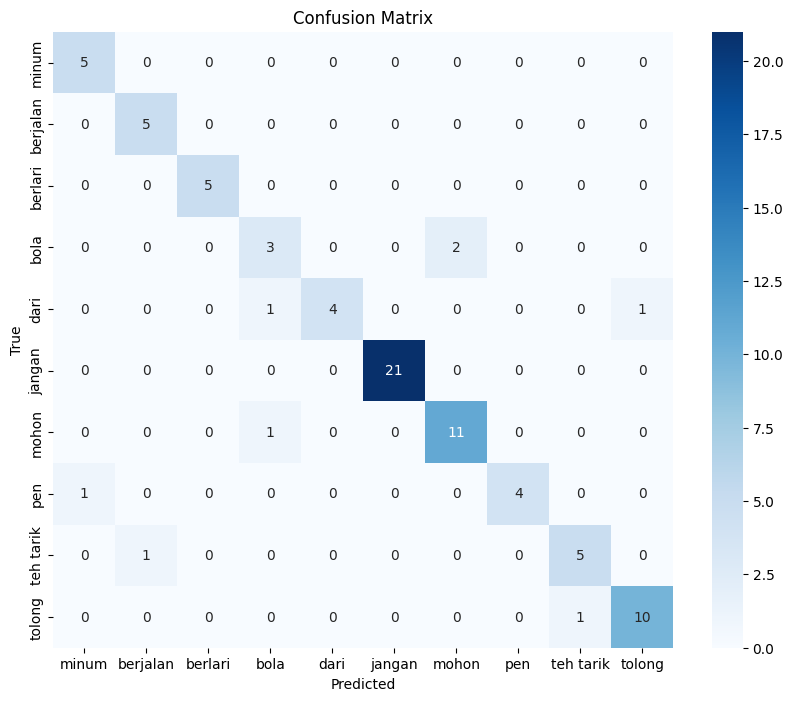

Classification Report:
              precision    recall  f1-score   support

       minum       0.83      1.00      0.91         5
    berjalan       0.83      1.00      0.91         5
     berlari       1.00      1.00      1.00         5
        bola       0.60      0.60      0.60         5
        dari       1.00      0.67      0.80         6
      jangan       1.00      1.00      1.00        21
       mohon       0.85      0.92      0.88        12
         pen       1.00      0.80      0.89         5
   teh tarik       0.83      0.83      0.83         6
      tolong       0.91      0.91      0.91        11

    accuracy                           0.90        81
   macro avg       0.89      0.87      0.87        81
weighted avg       0.91      0.90      0.90        81



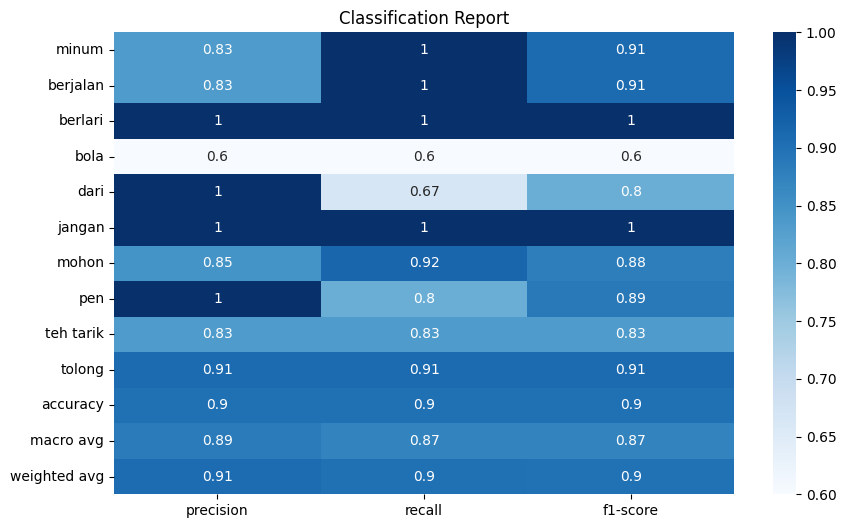

In [ ]:
# Evaluate the model on the GPU
model.eval()
print('Loading final trained model...')
model_filename = "trained_model.pth"
model.load_state_dict(torch.load(model_filename, map_location=device))

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    accuracy = (test_outputs.argmax(dim=1) == y_test).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

    # Convert predictions and true labels to numpy arrays
    predicted_labels = test_outputs.argmax(dim=1).cpu().numpy()
    true_labels = y_test.cpu().numpy()

    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=range(len(gestures)))
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=gestures, yticklabels=gestures)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print the classification report
    class_report = classification_report(true_labels, predicted_labels, target_names=gestures)
    print("Classification Report:")
    print(class_report)

    # Plot the classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame.from_dict(classification_report(true_labels, predicted_labels, target_names=gestures, output_dict=True)).T.drop(columns=['support'], errors='ignore'), annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()




# Model Testing

Testing the model with a single video

In [ ]:
import math

input_size = 258
hidden_size = 64
num_classes = len(gestures)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomLSTM(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load(model_filename, map_location=device))
model.eval()

colors = [(np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)) for _ in range(len(gestures))]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        width = int(prob * 100)
        cv2.rectangle(output_frame, (0, 60 + num * 40), (width, 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


sequence = []
predictions = []
threshold = 0.5 # Only show prediction if confidence is above 50%

video_path = '/content/drive/MyDrive/MSL_Project/videos/jangan/jangan_8_5_2.mp4'
cap = cv2.VideoCapture(video_path)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter('output_prediction.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Exit loop if video ends
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Prediction Logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if results.left_hand_landmarks or results.right_hand_landmarks:
            if len(sequence) == 30:
                # Scale the data using the scaler from training
                sequence_scaled = scaler.transform(np.array(sequence))
                input_tensor = torch.tensor(np.expand_dims(sequence_scaled, axis=0), dtype=torch.float32).to(device)

                # Predict
                with torch.no_grad():
                    res = model(input_tensor)

                # Convert logits to probabilities using Softmax
                probabilities = torch.softmax(res, dim=1)[0]
                max_prob = torch.max(probabilities).item()
                max_idx = torch.argmax(probabilities).item()

                print(f"Prediction: {gestures[max_idx]} ({max_prob:.2f})")

                # Visualization
                image = prob_viz(probabilities.cpu().numpy(), gestures, image, colors)

                # Show the winning class
                if max_prob > threshold:
                    cv2.putText(image, gestures[max_idx], (3,30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Write the modified frame to the output video
        out.write(image)

    cap.release()
    out.release()
    print("Video processing completes. Saved as 'output_prediction.mp4'")

Prediction: tolong (0.87)
Prediction: tolong (0.88)
Prediction: tolong (0.88)
Prediction: tolong (0.89)
Prediction: tolong (0.89)
Prediction: tolong (0.89)
Prediction: tolong (0.85)
Prediction: tolong (0.71)
Prediction: tolong (0.40)
Prediction: jangan (0.65)
Prediction: jangan (0.88)
Prediction: jangan (0.96)
Prediction: jangan (0.98)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: jangan (0.99)
Prediction: 

In [ ]:
from IPython.display import HTML
from base64 import b64encode

input_video = "output_prediction.mp4"
compressed_video = "output_compressed.mp4"

if os.path.exists(input_video):
    print(f"Found {input_video}. Converting for browser playback...")

    os.system(f"ffmpeg -i {input_video} -vcodec libx264 {compressed_video} -y")

    mp4 = open(compressed_video, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    display(HTML(f"""
    <video width=600 controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """))

else:
    print(f"Error: Could not find '{input_video}'.")

Found output_prediction.mp4. Converting for browser playback...
